In [44]:
!pip install pydot graphviz

In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [35]:
df_msf = pd.read_csv('data/pandas_feature_store_clean.csv')
df_msf.head(3)

,msf_seniority__c,msf_ltvcont__c,msf_recencyrecurringdonorcont__c,msf_rfvrecurringdonor__c,msf_valuetotalcont__c,msf_valuetotaldesc__c,msf_lifetime__c,msf_pressurecomplaint__c,msf_scoringrfvrecurringdonor__c,msf_averagedonorvalue__c,msf_percomssummary__c,days_elapsed_since_previous_modification,age,gender_Female,gender_Male,gender_Other,channel_Correo,channel_E-mail,channel_Llamada,channel_Otros,msf_newamount__c,msf_newannualizedquota__c,msf_newrecurringperiod__c,msf_closetype__c
0,22.0,3180.30,128.0,555,200.0,3,22.0,0,5.0,73.33,1,323.0,66,0,1,0,0,0,1,0,200.0,200.0,5,0
1,22.0,4830.17,4.0,555,360.0,3,22.0,0,5.0,32.86,0,36.0,89,0,1,0,0,0,1,0,90.0,360.0,3,0
2,22.0,2477.85,4.0,554,144.0,2,22.0,0,4.5,5.00,1,1302.0,78,1,0,0,0,0,1,0,12.0,144.0,1,0


##### Eliminamos columnas duplicadas

In [200]:
#df_msf_id.drop(columns=['npo02__totaloppamount__c', 'msf_valuetotaldesc__c'], inplace=True)

##### Eliminamos columnas duplicadas

In [265]:
#df_msf.drop(columns=['npo02__totaloppamount__c', 'msf_valuetotaldesc__c'], inplace=True)

##### Comprobamos nulos

In [10]:
print(df_msf.isna().sum())

msf_seniority__c                            0
msf_ltvcont__c                              0
msf_recencyrecurringdonorcont__c            0
msf_rfvrecurringdonor__c                    0
msf_valuetotalcont__c                       0
msf_valuetotaldesc__c                       0
msf_lifetime__c                             0
msf_pressurecomplaint__c                    0
msf_scoringrfvrecurringdonor__c             0
msf_averagedonorvalue__c                    0
msf_percomssummary__c                       0
days_elapsed_since_previous_modification    0
age                                         0
gender_Female                               0
gender_Male                                 0
gender_Other                                0
channel_Correo                              0
channel_E-mail                              0
channel_Llamada                             0
channel_Otros                               0
msf_newamount__c                            0
msf_newannualizedquota__c         

##### Vemos si el fichero está balanceado en cuanto a la variable objetivo

##### Importamos Tensorflow

In [24]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

##### Separamos las columnas predictoras y la columna a predecir (objetivo)

In [36]:
x = df_msf.drop(columns=["msf_closetype__c"])
y = df_msf.msf_closetype__c

##### Normalizamos los valores

In [37]:
x.head(3)

,msf_seniority__c,msf_ltvcont__c,msf_recencyrecurringdonorcont__c,msf_rfvrecurringdonor__c,msf_valuetotalcont__c,msf_valuetotaldesc__c,msf_lifetime__c,msf_pressurecomplaint__c,msf_scoringrfvrecurringdonor__c,msf_averagedonorvalue__c,msf_percomssummary__c,days_elapsed_since_previous_modification,age,gender_Female,gender_Male,gender_Other,channel_Correo,channel_E-mail,channel_Llamada,channel_Otros,msf_newamount__c,msf_newannualizedquota__c,msf_newrecurringperiod__c
0,22.0,3180.30,128.0,555,200.0,3,22.0,0,5.0,73.33,1,323.0,66,0,1,0,0,0,1,0,200.0,200.0,5
1,22.0,4830.17,4.0,555,360.0,3,22.0,0,5.0,32.86,0,36.0,89,0,1,0,0,0,1,0,90.0,360.0,3
2,22.0,2477.85,4.0,554,144.0,2,22.0,0,4.5,5.00,1,1302.0,78,1,0,0,0,0,1,0,12.0,144.0,1


##### Separamos los datos en un conjunto de train y en un conjunto de test (25% de los datos)

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=0)

## MLOps
![](images/mlflow-training.png)

##### Importamos MLFlow y creamos un grupo de experimentos

In [17]:
import mlflow
mlflow.set_tracking_uri('http://localhost:5000')

In [20]:
#experiment = mlflow.create_experiment("msf-quote")

In [21]:
experiment = mlflow.get_experiment_by_name("msf-quote")
experiment

<Experiment: artifact_location='mlflow-artifacts:/469179163190949195', creation_time=1696758244744, experiment_id='469179163190949195', last_update_time=1696758244744, lifecycle_stage='active', name='msf-quote', tags={}>

##### DNN model con Tensorflow

##### Registrándo todo en MLFlow creamos un modelo DNN con un clasificador binario que nos devuelva un valor con la probabilidad de aumentar la cuota

In [48]:
import time

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="msf-quote-increase-raw") as run:
    
    epochs=200
    learning_rate=0.01
    n_layers = 8
    nodes = [1024, 512, 256, 128, 64, 32, 16, 8]
    optimizer = 'adam'
    loss = 'binary_crossentropy'
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=0.0000001)
    
    # Registramos los parámetros
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('n_layers', n_layers)
    mlflow.log_param('nodes', nodes)
    mlflow.log_param('optimizer', optimizer)
    mlflow.log_param('loss', loss)
    
    # Assuming your data has a shape (None, input_dim), where input_dim is the number of input features
    input_dim = x_train.shape[1]  # replace this with the number of input features if not using x_train directly

    dense_layers = [tf.keras.layers.Dense(nodes[0], activation='relu', input_shape=(input_dim,))]  # Define the first layer with input shape
    for i in range(1, n_layers):
        dense_layer = tf.keras.layers.Dense(nodes[i], activation='relu')
        dense_layers.append(dense_layer)

    model = tf.keras.models.Sequential(dense_layers)
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Plot and save the model
    plot_model(model, to_file='images/dnn_model.png', show_shapes=True, show_layer_names=True)
   
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

    start_time = time.time()
    hist = model.fit(x=x_train, y=y_train, epochs=epochs, callbacks=[early_stop, reduce_lr], validation_data=(x_test, y_test))
    train_time = time.time() - start_time
    
    _, train_accuracy, train_precision, train_recall = model.evaluate(x_train, y_train)
    _, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test)

    # Registramos las métricas y el learning rate final
    mlflow.log_metric('train_time', train_time)
    mlflow.log_metric('train_accuracy', train_accuracy)
    mlflow.log_metric('train_precision', train_precision)
    mlflow.log_metric('train_recall', train_recall)
    mlflow.log_metric('test_accuracy', test_accuracy)
    mlflow.log_metric('test_precision', test_precision)
    mlflow.log_metric('test_recall', test_recall)
    final_lr = float(model.optimizer.lr.numpy())
    mlflow.log_param('final_learning_rate', final_lr)    
    
    # Registramos el modelo
    mlflow.tensorflow.log_model(model, 'msf-quote-increase-dnn-raw')
    #mlflow.tensorflow.log_model(model, 'heart-model-tf', registered_model_name="heart-model-tf")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/200
1613/1613 [==============================] - 13s 7ms/step - loss: 0.6829 - accuracy: 0.6741 - precision_7: 0.5443 - recall_7: 0.3132 - val_loss: 0.5796 - val_accuracy: 0.6989 - val_precision_7: 0.6463 - val_recall_7: 0.2507 - lr: 0.0010
Epoch 2/200
1613/1613 [==============================] - 11s 7ms/step - loss: 0.5838 - accuracy: 0.6974 - precision_7: 0.6235 - recall_7: 0.3002 - val_loss: 0.5622 - val_accuracy: 0.7050 - val_precision_7: 0.6380 - val_recall_7: 0.3033 - lr: 0.0010
Epoch 3/200
1613/1613 [==============================] - 11s 7ms/step - loss: 0.5776 - accuracy: 0.6983 - precision_7: 0.6283 - recall_7: 0.2980 - val_loss: 0.5665 - val_accuracy: 0.6933 - val_precision_7: 0.7385 - val_recall_7: 0.1499 - lr: 0.0010
Epoch 4/200
1613/1613 [==============================] - 11s 7ms/step - loss: 0.5743 - accuracy: 0.6977 

2023/10/13 18:43:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\mlala\AppData\Local\Temp\tmpg6lx_5zq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\mlala\AppData\Local\Temp\tmpg6lx_5zq\model\data\model\assets


##### Representamos en una gráfica la función de pérdida

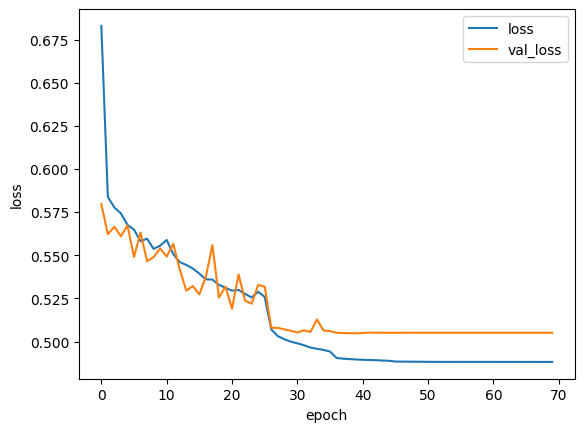

In [49]:
# Para mostrar gráficas
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

##### Procedemos a regsitrar el experimento en MLFlow y pasarlo a producción si procede

In [282]:
msf_experiments = mlflow.search_runs(search_all_experiments=True)
msf_experiments

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_precision,metrics.test_recall,metrics.train_time,metrics.test_accuracy,...,params.epochs,params.final_learning_rate,params.n_layers,params.optimizer,params.loss,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,09736a66a16a435dbd7718c2b577c220,469179163190949195,FINISHED,mlflow-artifacts:/469179163190949195/09736a66a...,2023-10-08 10:01:25.888000+00:00,2023-10-08 10:28:01.405000+00:00,0.597995,0.637535,1558.661452,0.60447,...,100,9.999999747378752e-06,5,adam,binary_crossentropy,msf-quote-increase-raw,"[{""run_id"": ""09736a66a16a435dbd7718c2b577c220""...",mlala,LOCAL,C:\Users\mlala\AppData\Local\Programs\Python\P...
1,ee8e32b1c96d4c91ad6e787f54ad14cb,469179163190949195,FAILED,mlflow-artifacts:/469179163190949195/ee8e32b1c...,2023-10-08 09:44:15.942000+00:00,2023-10-08 09:59:20.109000+00:00,NaN,NaN,NaN,NaN,...,100,None,5,adam,binary_crossentropy,msf-quote-increase-raw,None,mlala,LOCAL,C:\Users\mlala\AppData\Local\Programs\Python\P...


In [283]:
msf_experiments.loc[msf_experiments['tags.mlflow.runName'] == 'msf-quote-increase-raw']

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_precision,metrics.test_recall,metrics.train_time,metrics.test_accuracy,...,params.epochs,params.final_learning_rate,params.n_layers,params.optimizer,params.loss,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,09736a66a16a435dbd7718c2b577c220,469179163190949195,FINISHED,mlflow-artifacts:/469179163190949195/09736a66a...,2023-10-08 10:01:25.888000+00:00,2023-10-08 10:28:01.405000+00:00,0.597995,0.637535,1558.661452,0.60447,...,100,9.999999747378752e-06,5,adam,binary_crossentropy,msf-quote-increase-raw,"[{""run_id"": ""09736a66a16a435dbd7718c2b577c220""...",mlala,LOCAL,C:\Users\mlala\AppData\Local\Programs\Python\P...
1,ee8e32b1c96d4c91ad6e787f54ad14cb,469179163190949195,FAILED,mlflow-artifacts:/469179163190949195/ee8e32b1c...,2023-10-08 09:44:15.942000+00:00,2023-10-08 09:59:20.109000+00:00,NaN,NaN,NaN,NaN,...,100,None,5,adam,binary_crossentropy,msf-quote-increase-raw,None,mlala,LOCAL,C:\Users\mlala\AppData\Local\Programs\Python\P...


In [284]:
model_uri = f"runs:/09736a66a16a435dbd7718c2b577c220/msf-quote-increase-raw"
model_uri

'runs:/09736a66a16a435dbd7718c2b577c220/msf-quote-increase-raw'

In [285]:
model_version = mlflow.register_model(
    model_uri,
    "msf-quote-increase-raw"
)

Successfully registered model 'msf-quote-increase-raw'.
2023/10/08 12:28:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: msf-quote-increase-raw, version 1
Created version '1' of model 'msf-quote-increase-raw'.


In [286]:
client = mlflow.tracking.MlflowClient()
model_prod = client.transition_model_version_stage(
    name='msf-quote-increase-raw',
    version=1,
    stage="Production",
)

##### Leemos el fichero de features

In [287]:
df_msf_feature_store = pd.read_csv('data/feature_store.csv.gz', compression='gzip')
df_msf_feature_store

,whoid,activitydate,msf_seniority__c,gender__c,msf_ltvcont__c,msf_recencyrecurringdonorcont__c,msf_rfvrecurringdonor__c,npo02__totaloppamount__c,msf_valuetotalcont__c,msf_valuetotaldesc__c,msf_channel__c,days_elapsed_since_previous_modification,msf_newamount__c,msf_newannualizedquota__c,msf_newrecurringperiod__c,msf_closetype__c
0,0033Y00002uNQJvQAO,2023-01-04,22.0,0,4064.87,4.0,556,4064.87,528.0,4,2,19.0,44.0,528.0,1,Negativo
1,0033Y00002uNQMaQAO,2022-12-28,20.0,0,2040.00,4.0,544,2040.00,140.0,2,1,350.0,10.0,120.0,1,Positivo
2,0033Y00002uNQSMQA4,2022-10-20,22.0,1,961.10,277.0,552,961.10,55.0,1,1,465.0,55.0,55.0,5,Positivo
3,0033Y00002uNQU0QAO,2022-11-15,21.0,0,4788.00,4.0,555,4788.00,332.0,3,1,372.0,26.0,312.0,1,Positivo
4,0033Y00002uNQUUQA4,2023-02-09,20.0,0,5159.00,4.0,555,5159.00,364.0,3,1,449.0,22.0,264.0,1,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182933,0033Y00003TU66vQAD,2023-05-30,1.0,0,360.00,4.0,505,360.00,420.0,3,1,4.0,35.0,420.0,1,Positivo
182934,0033Y00003TUb7fQAD,2023-06-12,1.0,1,93.00,4.0,503,93.00,108.0,1,1,17.0,9.0,108.0,1,Positivo
182935,0033Y00003TUwXXQA1,2023-06-07,1.0,0,159.00,4.0,505,159.00,180.0,3,1,12.0,15.0,180.0,1,Positivo
182936,0033Y00003Up91NQAR,2023-06-16,1.0,0,67.00,4.0,502,67.00,84.0,1,1,21.0,7.0,84.0,1,Positivo


##### Eliminamos columnas que no necesitamos y la variable objetivo

In [288]:
df_msf_feature_store.drop(columns=['activitydate','npo02__totaloppamount__c', 'msf_valuetotaldesc__c','msf_closetype__c'], inplace=True)

##### Eliminaos regsitros con nulos en la columna days_elapsed_since_previous_modification

In [289]:
df_msf_feature_store.dropna(subset=['days_elapsed_since_previous_modification'], inplace=True)

In [290]:
df_msf_feature_store_no_id = df_msf_feature_store.copy()

##### Guardamos un fichero equivalente pero sin el id de socio

In [163]:
df_msf_feature_store_no_id = df_msf_feature_store.dropna(subset=['whoid'])

In [291]:
df_msf_feature_store_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182868 entries, 0 to 182937
Data columns (total 12 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   whoid                                     182868 non-null  object 
 1   msf_seniority__c                          182868 non-null  float64
 2   gender__c                                 182868 non-null  int64  
 3   msf_ltvcont__c                            182868 non-null  float64
 4   msf_recencyrecurringdonorcont__c          182868 non-null  float64
 5   msf_rfvrecurringdonor__c                  182868 non-null  int64  
 6   msf_valuetotalcont__c                     182868 non-null  float64
 7   msf_channel__c                            182868 non-null  int64  
 8   days_elapsed_since_previous_modification  182868 non-null  float64
 9   msf_newamount__c                          182868 non-null  float64
 10  msf_newannualizedquota__c

In [292]:
df_msf_feature_store_no_id = df_msf_feature_store.drop(columns=["whoid"])

In [253]:
df_msf_feature_store_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182868 entries, 0 to 182937
Data columns (total 11 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   msf_seniority__c                          182868 non-null  float64
 1   gender__c                                 182868 non-null  int64  
 2   msf_ltvcont__c                            182868 non-null  float64
 3   msf_recencyrecurringdonorcont__c          182868 non-null  float64
 4   msf_rfvrecurringdonor__c                  182868 non-null  int64  
 5   msf_valuetotalcont__c                     182868 non-null  float64
 6   msf_channel__c                            182868 non-null  int64  
 7   days_elapsed_since_previous_modification  182868 non-null  float64
 8   msf_newamount__c                          182868 non-null  float64
 9   msf_newannualizedquota__c                 182868 non-null  float64
 10  msf_newrecurringperiod__c

In [36]:
##### Normalizamos las features

In [293]:
from sklearn.preprocessing import MinMaxScaler
#cols_to_scale = ["msf_seniority__c","msf_ltvcont__c","msf_rfvrecurringdonor__c","msf_valuetotalcont__c","days_elapsed_since_previous_modification","msf_newamount__c","msf_newannualizedquota__c"]
#cols_to_scale = ["msf_ltvcont__c","msf_rfvrecurringdonor__c","msf_valuetotalcont__c"]
cols_to_scale = ["msf_seniority__c","msf_ltvcont__c","msf_recencyrecurringdonorcont__c","msf_rfvrecurringdonor__c","msf_valuetotalcont__c","msf_channel__c","days_elapsed_since_previous_modification","msf_newamount__c","msf_newannualizedquota__c","msf_newrecurringperiod__c"]
scaler = MinMaxScaler()
df_msf_feature_store_no_id[cols_to_scale] = scaler.fit_transform(df_msf_feature_store_no_id[cols_to_scale])
df_msf_feature_store_no_id.head(3)

,msf_seniority__c,gender__c,msf_ltvcont__c,msf_recencyrecurringdonorcont__c,msf_rfvrecurringdonor__c,msf_valuetotalcont__c,msf_channel__c,days_elapsed_since_previous_modification,msf_newamount__c,msf_newannualizedquota__c,msf_newrecurringperiod__c
0,0.583333,0,0.020947,0.000000,0.991870,0.024768,1.0,0.006614,0.006881,0.021003,0.0
1,0.527778,0,0.010471,0.000000,0.943089,0.006463,0.0,0.036199,0.001440,0.004681,0.0
2,0.583333,1,0.004890,0.280864,0.975610,0.002453,0.0,0.046478,0.008641,0.002080,1.0


##### Hacemos las predicciones para cada una de los registros

In [294]:
predictions = model.predict(df_msf_feature_store_no_id)

5715/5715 [==============================] - 4s 693us/step


In [38]:
# Añadimos las prediciones al dataframe con los ids de socios

In [295]:
df_msf_feature_store['prediction'] = predictions

In [296]:
df_msf_feature_store

,whoid,msf_seniority__c,gender__c,msf_ltvcont__c,msf_recencyrecurringdonorcont__c,msf_rfvrecurringdonor__c,msf_valuetotalcont__c,msf_channel__c,days_elapsed_since_previous_modification,msf_newamount__c,msf_newannualizedquota__c,msf_newrecurringperiod__c,prediction
0,0033Y00002uNQJvQAO,22.0,0,4064.87,4.0,556,528.0,2,19.0,44.0,528.0,1,0.171073
1,0033Y00002uNQMaQAO,20.0,0,2040.00,4.0,544,140.0,1,350.0,10.0,120.0,1,0.281458
2,0033Y00002uNQSMQA4,22.0,1,961.10,277.0,552,55.0,1,465.0,55.0,55.0,5,0.335936
3,0033Y00002uNQU0QAO,21.0,0,4788.00,4.0,555,332.0,1,372.0,26.0,312.0,1,0.458535
4,0033Y00002uNQUUQA4,20.0,0,5159.00,4.0,555,364.0,1,449.0,22.0,264.0,1,0.424301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182933,0033Y00003TU66vQAD,1.0,0,360.00,4.0,505,420.0,1,4.0,35.0,420.0,1,0.493076
182934,0033Y00003TUb7fQAD,1.0,1,93.00,4.0,503,108.0,1,17.0,9.0,108.0,1,0.276711
182935,0033Y00003TUwXXQA1,1.0,0,159.00,4.0,505,180.0,1,12.0,15.0,180.0,1,0.371433
182936,0033Y00003Up91NQAR,1.0,0,67.00,4.0,502,84.0,1,21.0,7.0,84.0,1,0.298411


In [297]:
df_msf_feature_store.to_csv('data/feature_store_with_predictions.csv')

##### Nos quedamos en un dataframe el id del socio con su correspondiente predicción

In [298]:
df_msf_id_predictions = df_msf_feature_store[['whoid', 'prediction']]
df_msf_id_predictions

,whoid,prediction
0,0033Y00002uNQJvQAO,0.171073
1,0033Y00002uNQMaQAO,0.281458
2,0033Y00002uNQSMQA4,0.335936
3,0033Y00002uNQU0QAO,0.458535
4,0033Y00002uNQUUQA4,0.424301
...,...,...
182933,0033Y00003TU66vQAD,0.493076
182934,0033Y00003TUb7fQAD,0.276711
182935,0033Y00003TUwXXQA1,0.371433
182936,0033Y00003Up91NQAR,0.298411
